In [1]:
# install groq python library
!pip install groq

# install pandas python library
!pip install pandas 

In [2]:
import os
import csv
import pandas as pd
from groq import Groq

In [3]:
'''
Data processing 

Manual inspection of csv files
Drinks
 - proper headings and rows
 - missing values

Food
 - all merged into one column separated by commas
 - all headings are also merged

Similarities
 - units of measurements are same

Differences
 - drinks has sodium data but foods do not
'''

'\nData processing \n\nManual inspection of csv files\nDrinks\n - proper headings and rows\n - missing values\n\nFood\n - all merged into one column separated by commas\n - all headings are also merged\n\nSimilarities\n - units of measurements are same\n\nDifferences\n - drinks has sodium data but foods do not\n'

In [4]:
# Helper functions to validate inputs

def clean_null_values(df):
    """
    Remove columns and rows with null values.
    - Drops columns where all values are null
    - Drops rows where any value is null
    """
    # Drop column if all values are null
    df.dropna(axis=1, how='all', inplace=True)
    
    # Drop row if one of the values is null
    df.dropna(inplace=True)
    
    return df

def strip_column_and_row_whitespace(df):
    """
    Strip whitespace from all column names and rows
    """
    df.columns = df.columns.str.strip() # strip column
    
    # Strip whitespace from row index only if it's a string index
    if df.index.dtype == 'object':
        df.index = df.index.str.strip()
    
    return df

def convert_to_numeric(df):
    """
    Convert all columns to numeric types.
    Drops rows containing string values that cannot be converted.
    """
    # Try to convert each column to numeric, mark non-numeric values as NaN
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Drop rows that now contain NaN (were strings)
    df.dropna(inplace=True)
    
    return df

def standardise_units_to_grams(df):
    """
    Convert columns ending with (kg) or (mg) to (g) with appropriate value conversions.
    - (kg) columns: multiply values by 1000
    - (mg) columns: divide values by 1000
    """
    new_columns = {}
    
    for col in df.columns:
        if col.endswith('(kg)'):
            # Convert kg to g (multiply by 1000)
            new_col_name = col[:-5]  # Remove (kg)
            df[col] = df[col] * 1000
            new_columns[col] = new_col_name
        elif col.endswith('(mg)'):
            # Convert mg to g (divide by 1000)
            new_col_name = col[:-5]  # Remove (mg)
            df[col] = df[col] / 1000
            new_columns[col] = new_col_name
        elif col.endswith('(g)'):
            # Remove (g) in name
            new_col_name = col[:-4]  # Remove (g)
            new_columns[col] = new_col_name
    
    # Rename the columns
    if new_columns:
        df.rename(columns=new_columns, inplace=True)
    
    return df

def detect_and_fix_single_column_csv(filepath):
    """
    Detect if CSV has all data in a single column (comma-separated within that column).
    If so, reparse it properly by splitting on commas.
    Returns a properly formatted DataFrame or None if file needs standard parsing.
    """
    try:
        with open(filepath, 'r', encoding='utf-16') as f:
            lines = f.readlines()
        if lines and lines[0].startswith(','):
            data = []
            for line in lines:
                line = line.strip()
                if line:
                    row = next(csv.reader([line]))
                    # Remove leading empty element
                    if row[0] == '':
                        row = row[1:]
                    data.append(row)
            if len(data) > 1:
                headers = data[0]
                rows = [x[1:] for x in data[1:]]
                index = [x[0].strip() for x in data[1:]]
                df = pd.DataFrame(rows, columns=headers, index=index)
                return df
        return None
        
    except Exception as e:
        # Ignore UTF-16 error
        if 'UTF-16 stream does not start with BOM' in str(e):
            return None
        else:
            print(f"Error parsing single column csv {filepath}: {e}")
            return None

In [5]:
## Data Loading

# possible issues
# missing data or wrong data (string input, null input)
# inconsistent formatting (file format all in one column, encoding)

def load_csv_file_into_dataframe(filepath):
    """
    Load a CSV file into a pandas DataFrame.
    Validation done:
        1. Detects and fixes CSV files with all data in a single column
        2. Handles missing or null values and drops bad rows/columns
        3. Strips whitespace from column names and row indices
        4. Converts all data to numeric and drops rows with non-numeric values
        5. Converts columns ending with (kg) or (mg) to (g) with value adjustments
    """
    try:
        # First, check if this is a single-column CSV
        df = detect_and_fix_single_column_csv(filepath)
        
        # If not a single-column issue, load normally
        if df is None:
            df = pd.read_csv(filepath,
                            na_values=["NA", "", "-"], # these values are considered null
                            index_col=0,
                            encoding='ISO-8859-1')
        
        # Apply validations
        df = strip_column_and_row_whitespace(df)
        df = convert_to_numeric(df)
        df = clean_null_values(df)
        df = standardise_units_to_grams(df)
        
        return df
    
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

In [6]:
'''
dont need to use
'''
def process_dataframe(df):
    """
    Print descriptive statistics and calculate column means.
    Returns a dictionary of column means.
    """
    summary_stats = df.describe()
    print("Summary Statistics:")
    print(summary_stats)
    
    column_means = {}

    # Loop through each column name in the DataFrame
    for column in df.columns:
        mean_value = df[column].mean()
        column_means[column] = mean_value
    
    # Print the final dictionary of means|
    print("\nCalculated Means:")
    print(column_means)
    return column_means

In [7]:
df_drinks = load_csv_file_into_dataframe('dataset/starbucks-menu-nutrition-drinks.csv')
df_food = load_csv_file_into_dataframe('dataset/starbucks-menu-nutrition-food.csv')

print(df_drinks.describe())
print(df_food.describe())

         Calories        Fat      Carb.      Fiber    Protein      Sodium
count   92.000000  92.000000  92.000000  92.000000  92.000000   92.000000
mean   135.163043   2.336957  24.739130   0.445652   4.152174   57.934783
std     93.853554   3.887928  15.214849   1.417040   5.691588   68.384627
min      0.000000   0.000000   0.000000   0.000000   0.000000    0.000000
25%     60.000000   0.000000  14.750000   0.000000   0.000000   10.000000
50%    130.000000   0.000000  25.500000   0.000000   1.000000   15.000000
75%    190.000000   4.125000  35.000000   0.000000   8.250000  115.000000
max    430.000000  26.000000  64.000000   8.000000  20.000000  240.000000
         Calories         Fat       Carb.       Fiber     Protein
count  113.000000  113.000000  113.000000  113.000000  113.000000
mean   356.637168   16.353982   41.486726    2.849558   11.469027
std    127.710685    8.297397   15.796764    2.888466    8.463230
min     90.000000    0.000000    5.000000    0.000000    1.000000
25% 

Food - Total Calories: 40300.0
Food - Average Calories: 356.6
Food - Fat-to-Protein Ratio: 1.43
Drinks - Total Calories: 12435.0
Drinks - Average Calories: 135.2
Drinks - Fat-to-Protein Ratio: 0.56
Food Avg Calories: 356.6, Drinks Avg Calories: 135.2
Food Avg Fat: 16.4, Drinks Avg Fat: 2.3
Food Avg Protein: 11.5, Drinks Avg Protein: 4.2


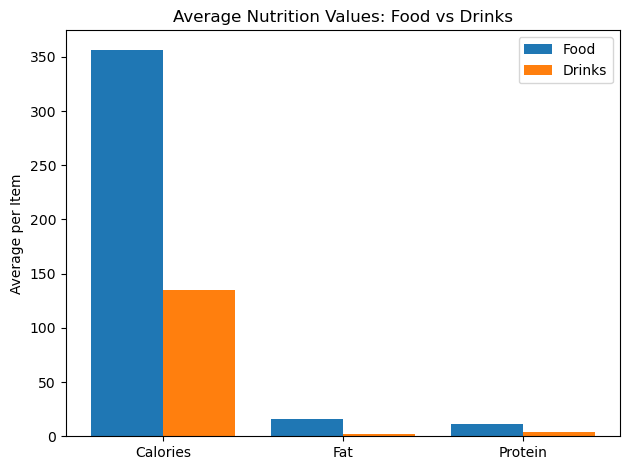

In [8]:
import matplotlib.pyplot as plt

def describe_nutrition_stats(df, type_name):
    """
    Print basic nutritional statistics for the given DataFrame.
    E.g., total calories, fat-to-protein ratio.
    """
    total_calories = df['Calories'].sum()
    avg_calories = df['Calories'].mean()
    total_fat = df['Fat'].sum()
    total_protein = df['Protein'].sum()
    fat_protein_ratio = total_fat / total_protein if total_protein != 0 else None
    print(f"{type_name} - Total Calories: {total_calories:.1f}")
    print(f"{type_name} - Average Calories: {avg_calories:.1f}")
    print(f"{type_name} - Fat-to-Protein Ratio: {fat_protein_ratio:.2f}")

def compare_key_metrics(df_food, df_drinks):
    """
    Compare average calories, fat, protein between food and drinks.
    """
    food_avg_cal = df_food['Calories'].mean()
    drink_avg_cal = df_drinks['Calories'].mean()
    food_avg_fat = df_food['Fat'].mean()
    drink_avg_fat = df_drinks['Fat'].mean()
    food_avg_prot = df_food['Protein'].mean()
    drink_avg_prot = df_drinks['Protein'].mean()
    print(f"Food Avg Calories: {food_avg_cal:.1f}, Drinks Avg Calories: {drink_avg_cal:.1f}")
    print(f"Food Avg Fat: {food_avg_fat:.1f}, Drinks Avg Fat: {drink_avg_fat:.1f}")
    print(f"Food Avg Protein: {food_avg_prot:.1f}, Drinks Avg Protein: {drink_avg_prot:.1f}")

def plot_nutrition_comparison(df_food, df_drinks):
    """
    Generate a bar chart comparing averages for calories, fat, and protein.
    """
    nutrients = ['Calories', 'Fat', 'Protein']
    food_means = [df_food[n].mean() for n in nutrients]
    drink_means = [df_drinks[n].mean() for n in nutrients]
    
    x = range(len(nutrients))
    plt.bar(x, food_means, width=0.4, label='Food', align='center')
    plt.bar([i + 0.4 for i in x], drink_means, width=0.4, label='Drinks', align='center')
    plt.xticks([i + 0.2 for i in x], nutrients)
    plt.ylabel("Average per Item")
    plt.title("Average Nutrition Values: Food vs Drinks")
    plt.legend()
    plt.tight_layout()
    plt.show()

describe_nutrition_stats(df_food, "Food")
describe_nutrition_stats(df_drinks, "Drinks")
compare_key_metrics(df_food, df_drinks)
plot_nutrition_comparison(df_food, df_drinks)



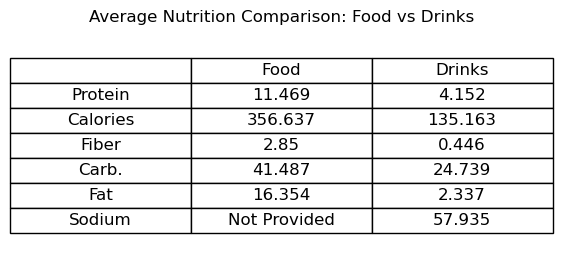

In [10]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy

def get_union_of_keys(df1, df2):
    """
    Retrieves the union of all column names (keys) from two pandas DataFrames.
    Returns a list containing all unique column names present in either DataFrame.
    """
    # 1. Get the columns from the first DataFrame as a list
    keys_df1 = df1.columns.tolist()

    # 2. Get the columns from the second DataFrame as a list
    keys_df2 = df2.columns.tolist()

    # 3. Combine the two lists and convert to a set to get the unique union
    all_keys = set(keys_df1 + keys_df2)

    return list(all_keys)

def get_average_nutrition_each_column(df):
    """
    Generates a dictionary for each column of the dataframe with its average
    Outputs a default dictionary where missing keys have values "Not Provided"
    """
    nutrients = df.columns
    averages = defaultdict(lambda: "Not Provided")  # default value for missing keys

    for n in nutrients:
        averages[n] = df[n].mean()
    return averages

def compare_nutrition_table(df_food, df_drinks):
    """
    Generates a table plot comparing average nutrition info between food and drinks.
    """
    food_avg = get_average_nutrition_each_column(df_food)
    drink_avg = get_average_nutrition_each_column(df_drinks)

    # get all possible keys
    nutrients = get_union_of_keys(df_food, df_drinks)

    # rounds values with decimal places
    food_values = [round(food_avg[n], 3) if isinstance(food_avg[n], (float, numpy.floating)) else food_avg[n] for n in nutrients]
    drink_values = [round(drink_avg[n], 3) if isinstance(drink_avg[n], (float, numpy.floating)) else drink_avg[n] for n in nutrients]

    cell_text = []
    for i, n in enumerate(nutrients):
        cell_text.append([food_values[i], drink_values[i]])

    fig, ax = plt.subplots(figsize=(7, 3))
    ax.axis('tight')
    ax.axis('off')
    table_data = [[n, food_values[i], drink_values[i]] for i, n in enumerate(nutrients)]
    
    table = ax.table(cellText=table_data,
                     colLabels=["", "Food", "Drinks"],
                     loc='center',
                     cellLoc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    
    plt.title("Average Nutrition Comparison: Food vs Drinks")
    plt.show()

# Example usage:
compare_nutrition_table(df_food, df_drinks)
#print(get_average_nutrition_each_column(df_drinks))
